In [1]:
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

from model import PolicyModel

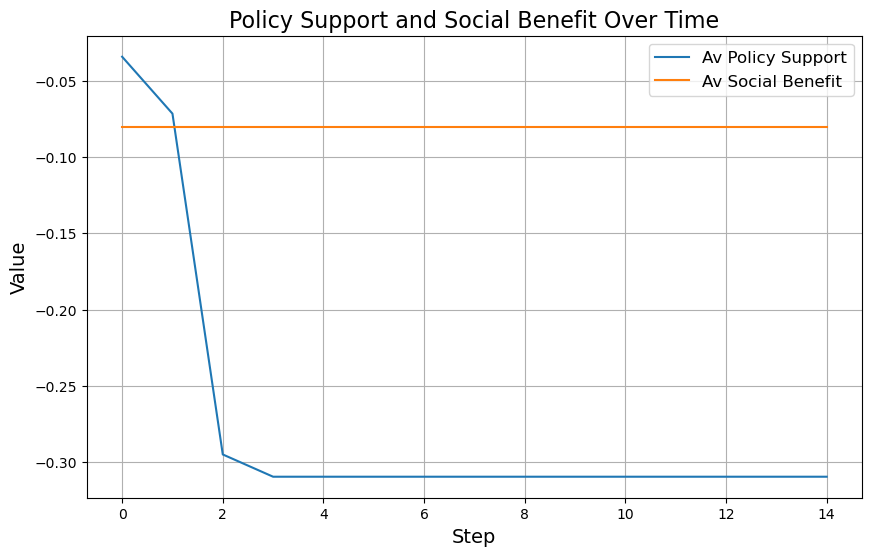

In [5]:
# Set up and run the model
my_model = PolicyModel(
    num_agents=100,               # Number of agents in the model
    privileged_fraction=0.3,      # Fraction of privileged nodes
    marginalized_fraction=0.3,    # Fraction of marginalized nodes
    steps=15                     # Number of simulation steps
)

# Run the model for the specified number of steps
for i in range(my_model.steps):
    print(f"now running step {i}", end="\r", flush=True)
    # for n in my_model.agents:
    #   print(f"{n} opinion is {n.opinion}")
    my_model.step()

# Collect and visualize the results
data = my_model.datacollector.get_model_vars_dataframe()

plt.figure(figsize=(10, 6))
plt.plot(data["Net Policy Support"], label="Av Policy Support")
plt.plot(data["Net Social Benefit"], label="Av Social Benefit")
plt.title("Policy Support and Social Benefit Over Time", fontsize=16)
plt.xlabel("Step", fontsize=14)
plt.ylabel("Value", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.show()

In [6]:
for a in my_model.agents:
  print(a.marginalized, a.impact, a.opinion)

True 0 -0.4996646498695335
True 1 -0.4999999943972036
False -1 0.49998329857815205
True 0 -0.4996646498695335
True 0 -0.4996646498695335
True 0 -0.4996646498695335
False 0 -0.4996646498695335
False -1 0.49998329857815205
False 0 -0.4996646498695335
False -1 0.4998766054240137
False -1 0.4998766054240137
True 1 -0.4999999847700205
False -1 0.49998329857815205
True 1 -0.4999999847700205
False 0 -0.4996646498695335
False 0 -0.4996646498695335
False 0 -0.4996646498695335
False -1 0.49998329857815205
False -1 0.49998329857815205
False 0 -0.4996646498695335
True 0 -0.4996646498695335
False -1 0.4999546021312976
False -1 0.49998329857815205
True 0 -0.4996646498695335
False 0 -0.4996646498695335
False 0 -0.4996646498695335
False 0 -0.4996646498695335
False 0 -0.4996646498695335
True 1 -0.4999999943972036
False 0 -0.4996646498695335
True 1 -0.4999999943972036
False -1 0.49998329857815205
False 0 -0.4996646498695335
False 0 -0.4996646498695335
False 0 -0.4996646498695335
True 1 -0.49999999439720